# Loading in all necessary libraries

In [1]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings("ignore")

from numpy.random import seed
seed(42)
import tensorflow as tf
tf.random.set_seed(42)
import random
random.seed(42)

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, Dropout, MaxPooling1D, BatchNormalization, ReLU, AveragePooling1D, GlobalAveragePooling1D
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from google.colab import drive

!pip install keras-tuner -q
import keras_tuner
from keras_tuner import RandomSearch

from google.colab import drive

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.3 MB/s eta 0:00:00


# Loading in data

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# reading in male only csv that was saved from the Ensemble Learning w Bagging code file
file_path = '/content/drive/My Drive/DS340/CHD_men.csv'
male_data = pd.read_csv(file_path, sep=",")

male_data.head(10)

age  height  weight  sys_bp  dia_bp  cholesterol  gluc  smoke  alco  \
0  50.392     168    62.0     110      80            1     1      0     0   
1  48.282     169    82.0     150     100            1     1      0     0   
2  61.874     178    95.0     130      90            3     3      0     0   
3  51.548     173    60.0     120      80            1     1      0     0   
4  40.523     165    60.0     120      80            1     1      0     0   
5  39.814     181    95.0     130      90            1     1      1     1   
6  45.978     172   112.0     120      80            1     1      0     0   
7  59.603     162    56.0     120      70            1     1      1     0   
8  54.186     163    83.0     120      80            1     1      0     0   
9  64.044     156    45.0     110      60            1     1      0     0   

   active  cardio  
0       1       0  
1       1       1  
2       1       1  
3       1       0  
4       0       0  
5       1       0  
6       0       1  
7       1       0  
8       1       0  
9       1       0

# Creating the CNN model structure

In [4]:
# Building CNN model based off of CNN structure from paper 2

# had to keep padding as "same" - does not match the paper
# also changed from softmax to sigmoid, as sigmoid is better for binary classification
# got rid of average pooling - had issues with hyperparameter tuning

def gender_model(hp):
    model = Sequential()

    # Layer 1: Dense layer w/ 64 neurons, batch normalization, ReLU activation and dropout
    # hyperparameter tuning ==> # of neurons & dropout rate
    model.add(Dense(units = hp.Int('Dense1_neurons', min_value = 32, max_value = 512, step = 32),
                    input_shape=(11, 1)))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(Dropout(hp.Float('Dense1_dropout', min_value = 0.1, max_value = 0.5, step = 0.05)))


    # Layer 2: Convolutional layer w/ 2 filters, kernel size of 4, 'same' padding, 2 strides, Batch Normalization, ReLU and average pooling
    model.add(Conv1D(filters=2,
                     kernel_size= 4,
                     strides = 2,
                     padding = 'same'))
    model.add(BatchNormalization())
    model.add(ReLU())


    # Layer 3: Convolutional layer w/ 4 filters, kernel size of 4, 'same' padding, 2 strides, Batch Normalization, ReLU and average pooling
    model.add(Conv1D(filters=4,
                     kernel_size = 6,
                     strides = 2,
                     padding = 'same'))
    model.add(BatchNormalization())
    model.add(ReLU())

    # had to add because of errors
    model.add(Flatten())

    # Layer 4: Dense layer with 512 neurons, Batch normalization, ReLU and dropout
    # Hyperparameter tuning ==> # of neurons & dropout rate
    model.add(Dense(units = hp.Int('Dense2_neurons', min_value = 32, max_value = 512, step = 32)))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(Dropout(hp.Float('Dense2_dropout', min_value = 0.1, max_value = 0.5, step = 0.05)))

    # Layer 5: Dense layer with 1 neuron
    model.add(Dense(units=1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Splitting data into train-validation-test sets

In [6]:
X = male_data.drop(columns=['cardio'])
y = male_data['cardio']


# Split the data into training and test sets (80% train, 20% test)
# stratify parameter is used to split dataset into training and testing in way that is proportional to the cardio target variable
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.25, random_state=42, stratify=y_train_full)

# Train-val-test split = 60%, 20%, 20%

## Scaling and reshaping data

In [7]:
# scaling data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [8]:
# reshaping the data
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Hyperparameter tuning

In [9]:
# Instantiate Keras Tuner search
tuner = RandomSearch(gender_model, objective='val_accuracy', max_trials=3, executions_per_trial=3,
                          directory='./DS340_CHD', project_name='tuner_male')


# Search for the best hyperparameters
tuner.search(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

# Get the best model and evaluate on the test set
best_model = tuner.get_best_models(num_models=1)[0]
test_loss, test_acc = best_model.evaluate(X_test, y_test)
print(f'Test Loss (after tuning): {test_loss}, Test Accuracy (after tuning): {test_acc}')

Trial 3 Complete [00h 04m 21s]
val_accuracy: 0.7308549284934998

Best val_accuracy So Far: 0.7312726378440857
Total elapsed time: 00h 11m 02s
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7293 - loss: 0.5467
Test Loss (after tuning): 0.547873318195343, Test Accuracy (after tuning): 0.7272347807884216


# Getting the best hyperparameters

In [10]:
# Get the best hyperparameters and model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the best model with the optimal hyperparameters
best_model = tuner.hypermodel.build(best_hps)

# Summary of the best model
best_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                      │ (None, 11, 448)             │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 11, 448)             │           1,792 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_4 (ReLU)                       │ (None, 11, 448)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 11, 448)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 6, 2)                │           3,586 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 6, 2)                │               8 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_5 (ReLU)                       │ (None, 6, 2)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 3, 4)                │              52 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 3, 4)                │              16 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_6 (ReLU)                       │ (None, 3, 4)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 12)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 160)                 │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 160)                 │             640 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_7 (ReLU)                       │ (None, 160)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 160)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,231 (36.06 KB)

 Trainable params: 8,003 (31.26 KB)

 Non-trainable params: 1,228 (4.80 KB)

In [11]:
# retrieving best value for tuned parameters

dropout_val1 = best_hps.get('Dense1_dropout')
dropout_val2 = best_hps.get('Dense2_dropout')
neurons_val1 = best_hps.get('Dense1_neurons')
neurons_val2 = best_hps.get('Dense2_neurons')
print(f"Dropout value for Dense1: {dropout_val1}")
print(f"Dropout value for Dense2: {dropout_val2}")
print("")
print(f"Number of neurons for Dense1: {neurons_val1}")
print(f"Number of neurons for Dense2: {neurons_val2}")

Dropout value for Dense1: 0.4
Dropout value for Dense2: 0.35

Number of neurons for Dense1: 448
Number of neurons for Dense2: 160


In [14]:
# Evaluating the model on the test set
test_loss, test_acc = best_model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_acc}')

150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5622 - loss: 0.6931
Test Loss: 0.6931242346763611, Test Accuracy: 0.5651628971099854


In [15]:
# Make predictions on the test set
y_pred_prob = best_model.predict(X_test)

# Convert probabilities to binary predictions
y_pred = (y_pred_prob > 0.5).astype("int32")

# Evaluating performance using various metrics
print("\nAccuracy Score:", accuracy_score(y_test, y_pred))
print("")
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step

Accuracy Score: 0.5651629072681704


Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.52      0.55      2396
           1       0.56      0.61      0.58      2392

    accuracy                           0.57      4788
   macro avg       0.57      0.57      0.56      4788
weighted avg       0.57      0.57      0.56      4788


Confusion Matrix:
 [[1247 1149]
 [ 933 1459]]


# Bagging

In [12]:
!pip install scikeras
!pip install --upgrade scikit-learn
from scikeras.wrappers import KerasClassifier
from sklearn.ensemble import BaggingClassifier

def build_best_model():
    model = tuner.hypermodel.build(best_hps)
    return model

model = KerasClassifier(build_fn=build_best_model, epochs=20, batch_size=32, verbose=0)

# Now fit the bagging model
bagging_model = BaggingClassifier(estimator=model, n_estimators=10, random_state=42)
# Flatten X_train for the BaggingClassifier
X_train_flat = X_train.reshape(X_train.shape[0], -1)

# Fit bagging with flattened data
bagging_model.fit(X_train_flat, y_train)

BaggingClassifier(estimator=KerasClassifier(batch_size=32, build_fn=<function build_best_model at 0x7aee8fca7f40>, epochs=20, verbose=0),
                  random_state=42)

In [17]:
# Step 8: Evaluate the model on the test set
from sklearn.metrics import accuracy_score

# Predict on the test data
y_pred = bagging_model.predict(X_test.reshape(X_test.shape[0], -1))  # Reshape X_test if needed

confusion_matrix = confusion_matrix(y_test, y_pred)

# Calculate accuracy & other evaluation metrics
test_acc = accuracy_score(y_test, y_pred)
print(f'Test Accuracy: {test_acc}')
print("")
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix)

Test Accuracy: 0.7291144527986633


Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.80      0.75      2396
           1       0.77      0.66      0.71      2392

    accuracy                           0.73      4788
   macro avg       0.73      0.73      0.73      4788
weighted avg       0.73      0.73      0.73      4788


Confusion Matrix:
 [[1919  477]
 [ 820 1572]]


In [23]:
# getting FPR, TPR, FNR and TNR rates
TN = confusion_matrix[0, 0]
FP = confusion_matrix[0, 1]
FN = confusion_matrix[1, 0]
TP = confusion_matrix[1, 1]

FPR = round(FP / (FP + TN),3)
FNR = round(FN / (FN + TP),3)
TPR = round(TP / (TP + FN),3)
TNR = round(TN / (TN + FP),3)

print(f'False Positive Rate (FPR): {FPR}')
print(f'False Negative Rate (FNR): {FNR}')
print(f'True Positive Rate (TPR): {TPR}')
print(f'True Negative Rate (TNR): {TNR}')

False Positive Rate (FPR): 0.199
False Negative Rate (FNR): 0.343
True Positive Rate (TPR): 0.657
True Negative Rate (TNR): 0.801


In [19]:
import shap

# getting training and testing sample
# had to use same size because of RAM issues with Colab (crashed if number was too high)
X_train_sample = shap.sample(X_train, 50)
X_test_sample = shap.sample(X_test, 50)

In [20]:
# reshaping data
X_train_reshaped = X_train_sample.reshape(X_train_sample.shape[0], -1)
X_test_reshaped = X_test_sample.reshape(X_test_sample.shape[0], -1)

In [21]:
import joblib
import os

drive_path = '/content/drive/My Drive/DS340/'  # Replace with your folder name
explainer_file = os.path.join(drive_path, 'shap_explainer_males.pkl')


if os.path.exists(explainer_file):
  explainer = joblib.load(explainer_file)
else:
  # Creating SHAP explainer
  explainer = shap.KernelExplainer(bagging_model.predict, X_train_reshaped,approximate = True)

  # Calculating SHAP values (this might take some time)
  shap_values = explainer.shap_values(X_test_reshaped)

  # saving explainer to google drive
  joblib.dump(explainer, explainer_file)

  0%|          | 0/50 [00:00<?, ?it/s]

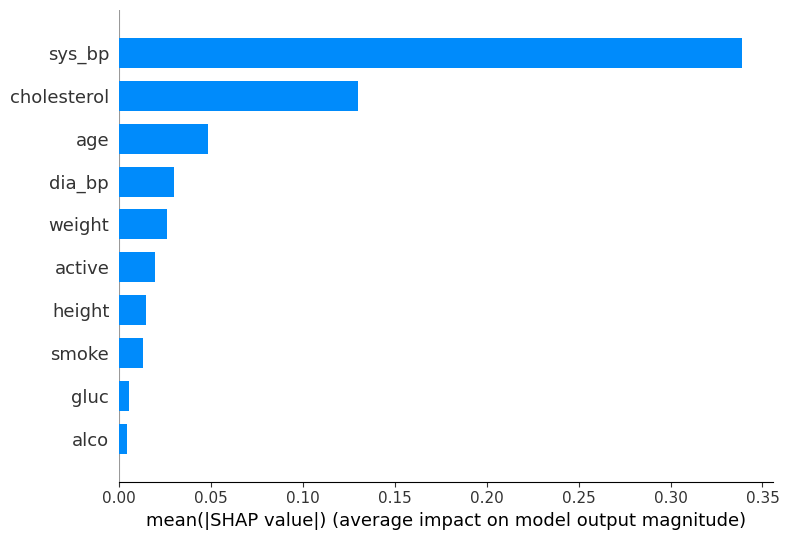

In [22]:
# setting feature names for plots
feature_names = ['age', 'height', 'weight', 'sys_bp', 'dia_bp', 'cholesterol', 'gluc', 'smoke', 'alco', 'active']

# creating SHAP summary plot
shap.summary_plot(shap_values, X_test_reshaped, feature_names=feature_names, plot_type='bar')

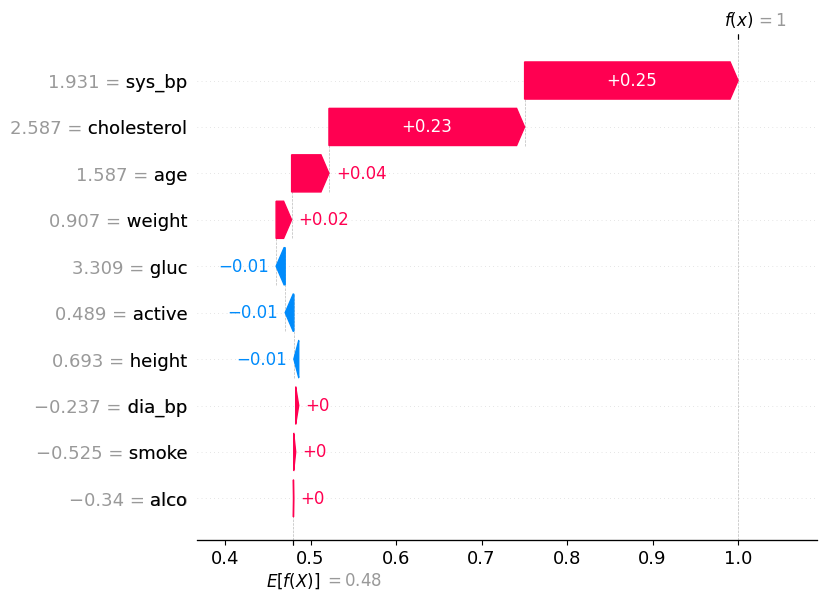

In [24]:
# creating SHAP waterfall plot
shap.waterfall_plot(shap.Explanation(values=shap_values[0], base_values=explainer.expected_value, data=X_test_reshaped[0], feature_names=feature_names))

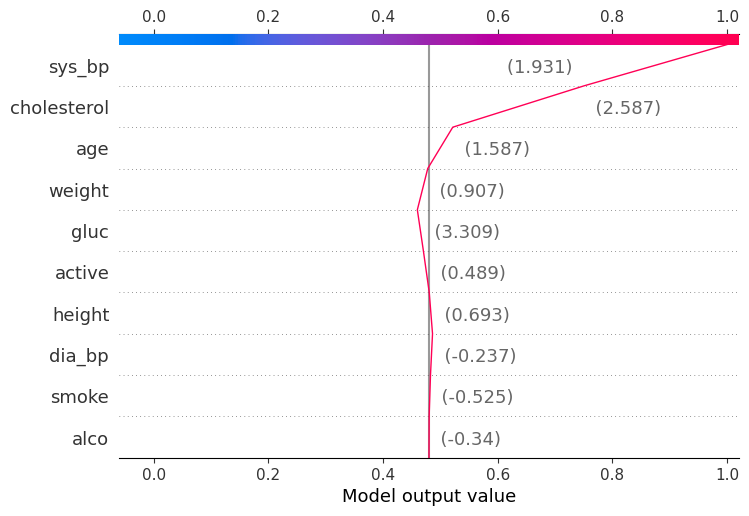

In [25]:
# creating SHAP decision plot
shap.decision_plot(explainer.expected_value, shap_values[0], X_test_reshaped, feature_names=feature_names)

In [26]:
!pip install lime
from lime.lime_tabular import LimeTabularExplainer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=46611f4e37e73d5a334aa112ca221421f5cfad536c614d6f8d705cb3f43d0955
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [28]:
# creating LIME explainer
lime_explainer = LimeTabularExplainer(
    training_data=X_train_reshaped,
    feature_names= feature_names,
    class_names= ['No CHD', 'CHD'],
    mode='classification'
)

In [30]:
# doing LIME for first test instance
test_instance = X_test_reshaped[0]

# Generate explanation for the prediction
lime_explanation = lime_explainer.explain_instance(
    data_row=test_instance,
    predict_fn=bagging_model.predict_proba  # Function to predict probabilities
)

lime_explanation.show_in_notebook(show_table=True)

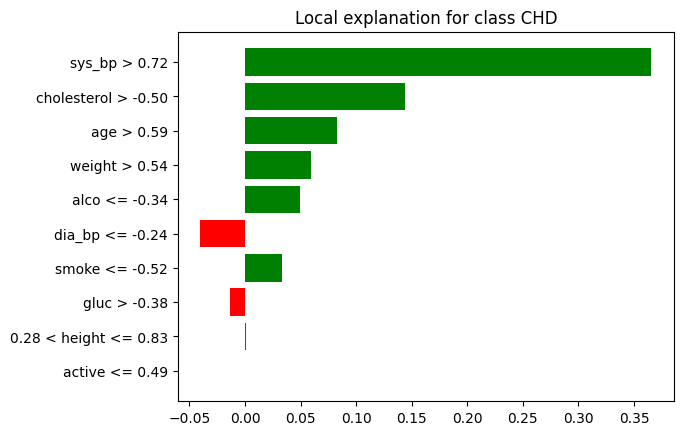

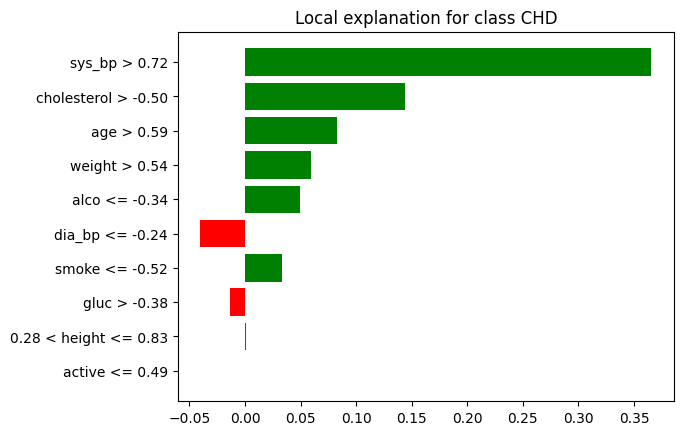

In [31]:
# different way of visualizing LIME plots
lime_explanation.as_pyplot_figure()

In [34]:
# doing LIME for tenth test instances
test_instance = X_test_reshaped[9]

# Generate explanation for the prediction
lime_explanation = lime_explainer.explain_instance(
    data_row=test_instance,
    predict_fn=bagging_model.predict_proba  # Function to predict probabilities
)

lime_explanation.show_in_notebook(show_table=True)

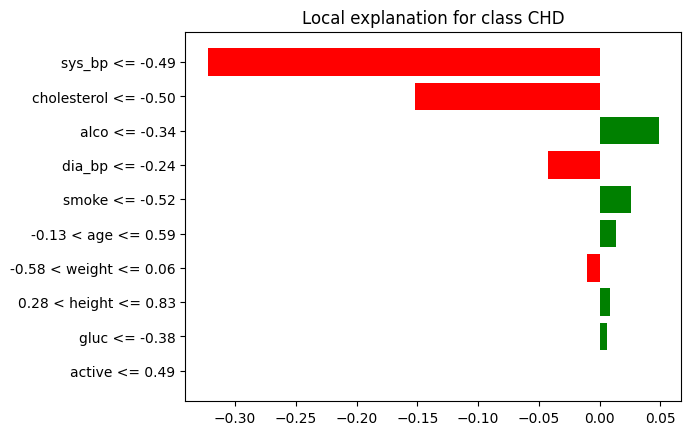

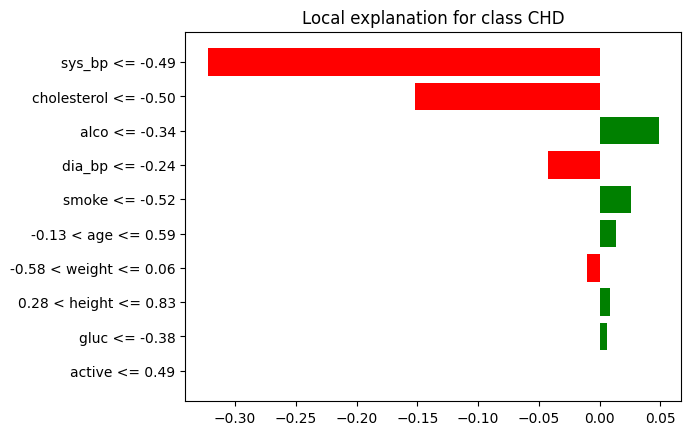

In [35]:
# different way of visualizing LIME plots
lime_explanation.as_pyplot_figure()